# Text Clustering

----

## Contents:

`Total Read Time ~ 20 mins.`

`Total Execution Time ~ 45 mins.`

#### Clustering
1. Imports
2. Directory Setup
3. Load preprocessed data
4. 

## 1. Imports

In [1]:
## Imports
'''Python 3.8.0'''

# Standard libs
import os
import sys
import json
import warnings
import re
import io
from io import StringIO
import inspect
import shutil
import ast
import string
import time
import pickle
import glob
import traceback
import multiprocessing
import requests
import logging
import math
from ast import literal_eval
import pytz
from itertools import chain
from string import Template
from datetime import datetime, timedelta
from dateutil import parser
import base64
from collections import defaultdict, Counter, OrderedDict
from contextlib import contextmanager
import unicodedata
from functools import reduce
import itertools
import tempfile
from typing import Any, Dict, List, Callable, Optional, Tuple, NamedTuple, Union
from functools import wraps
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# graph
import networkx as nx

# Required pkgs
import numpy as np
from numpy import array, argmax
import pandas as pd
import ntpath
import tqdm

# General text correction - fit text for you (ftfy) and others
import ftfy
from fuzzywuzzy import fuzz
from wordcloud import WordCloud
from spellchecker import SpellChecker

# scikit-learn
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, jaccard_score, silhouette_score, homogeneity_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.base import BaseEstimator, TransformerMixin

# scipy
from scipy import spatial, sparse
from scipy.sparse import coo_matrix, vstack, hstack
from scipy.spatial.distance import euclidean, jensenshannon, cosine, cdist
from scipy.io import mmwrite, mmread
from scipy.stats import entropy
from scipy.cluster.hierarchy import dendrogram, ward, fcluster
import scipy.cluster.hierarchy as sch
from scipy.sparse.csr import csr_matrix
from scipy.sparse.lil import lil_matrix
from scipy.sparse.csgraph import connected_components
from sklearn import metrics
from scipy.spatial.distance import cdist

# sparse_dot_topn: matrix multiplier
from sparse_dot_topn import awesome_cossim_topn
import sparse_dot_topn.sparse_dot_topn as ct

# Gensim
import gensim
from gensim.models import Phrases, Word2Vec, KeyedVectors, FastText, LdaModel
from gensim import utils
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api
from gensim import models, corpora, similarities

# NLTK
import nltk
#nltk_model_data_path = "/somepath/"
#nltk.data.path.append(nltk_model_data_path)
from nltk import FreqDist, tokenize, sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
from nltk.translate.bleu_score import sentence_bleu
print("NLTK loaded.")

# Spacy
import spacy
print("Spacy loaded.")

# Plots
from matplotlib import pyplot as plt, ticker as ticker
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import offline
%matplotlib inline

# Theme settings
pd.set_option("display.max_columns", 80)
sns.set_context('talk')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/var/folders/p0/4xbhb9g13ydfpnpwd04tq0pm0000gn/T/ipykernel_70044/3839943381.py:40: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

/Users/pranjalpathak/opt/anaconda3/envs/Python_3.8/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/var/folders/p0/4xbhb9g13ydfpnpwd04tq0pm0000gn/T/ipykernel_70044/3839943381.py:79: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  from scipy.sparse.csr import csr_matrix
/var/folders/p0/4xbhb9g13ydfpnpwd04tq0pm0000gn/T/ipykernel_70044/3839943381.py:80: DeprecationWarning: Please use `lil_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.lil` namespace is deprecated.
  from scipy.sparse.lil import lil_matrix


NLTK loaded.


2023-02-23 01:36:55.429048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Spacy loaded.


## 2. Directory Setup

In [2]:
root_dir = os.path.abspath("../")
data_dir = os.path.join(root_dir, "data")
models_dir = os.path.join(root_dir, "models")
output_dir = os.path.join(root_dir, "output")

nlp_resources_fp = os.path.join(os.path.join(root_dir, "models"), "resources")
spacy_model_data_path = os.path.join(os.path.join(root_dir, "models"), "spacy/en_core_web_lg-3.5.0/en_core_web_lg/en_core_web_lg-3.5.0")
sbert_model_fp = os.path.join(os.path.join(root_dir, "models"), "transformer_models/all-distilroberta-v1/")

# load spacy
nlp = spacy.load(spacy_model_data_path)  # disabling: nlp = spacy.load(spacy_data_path, disable=['ner'])

## 3. Load Preprocessed Data

In [3]:
df = pd.read_csv(os.path.join(data_dir, "processed_cuboulder_TwitterData.csv"))
df.hastags = df.hastags.apply(lambda x: literal_eval(x) if str(x) not in ['none', 'nan', 'np.nan', 'null', ''] else None)
print("Dataset to be clustered has #records: ", df.shape[0])

Dataset to be clustered has #records:  3394


## 4. Load Vectorized data

- The vectorization was performed in a separate notebook `DataVectorization.ipynb`


- In a nutshell, various methods were compared such as, Tfidf, Spacy, Universal Sentence Encoder, Doc2Vec, and Roberta-Base-Bert. 



- The final vectorization engine used was: distilled-roberta-version1 which is a robert based sentence transformers model fine-tuned on twitter data, provided by cardiffnlp under GNU3 license.


- These embeddings are already scaled and normalized, and are in a numpy format.

In [4]:
# loading vectorized embeddings

embeddings_fp = os.path.join(os.path.join(root_dir, "models"), "processed_text_embeddings.pkl")

with open(embeddings_fp,'rb') as f:
    embeddings = pickle.load(f)
    print(type(embeddings), " Dimensions: ", embeddings.shape)
    
X = embeddings
X

<class 'numpy.ndarray'>  Dimensions:  (3394, 768)


array([[ 0.20002635, -0.4575919 ,  0.15053652, ...,  0.5564049 ,
        -0.05423872,  0.3733367 ],
       [ 0.16106713, -0.48768777,  0.00891125, ...,  0.30815083,
         0.3740416 , -0.06682304],
       [ 0.07822946,  0.0725686 ,  0.10943291, ...,  0.10491418,
        -0.12087219, -0.14334728],
       ...,
       [ 0.1118618 ,  0.18647514, -0.00605653, ..., -0.2965798 ,
        -0.04961137,  0.02005607],
       [-0.2032648 , -0.16141923,  0.0596775 , ..., -0.39297703,
        -0.63094133,  0.33786762],
       [-0.06183682, -0.3781776 ,  0.2584182 , ..., -0.5534396 ,
         0.14211999, -0.8266083 ]], dtype=float32)

Context:


- An $embedding$ is a numerical representation of words, phrases, or sentences that captures the meaning and context (both semantic and syntactic) of the text in a high-dimensional space. 


- In the case of a document (one or more sentences), an $embedding$ represents the meaning of these sentences in a way that can be processed by machine learning models.


- A $Transformer$ model is a type of neural network that is commonly used for natural language processing. One of the main features of the Transformer model is its ability to generate word embeddings that capture the meaning and context of a sentence. These embeddings are generated by processing the sentence through the layers of the Transformer model.


Our data:

- In our dataset (tweets) each sentence have been vectorized into a vector of [1 x 768] dimensions.


- When we say that a text sentence is embedded into $768 \space dimensions$ by a pre-trained Transformer model, we mean that the sentence is **now represented as a vector of 768 numbers**, where each number in the vector corresponds to a different dimension in the embedding space. 


- These dimensions were learned by the Transformer model during training and represent different aspects of the meaning and context of the sentence.


- For example, one dimension of the embedding vector might correspond to the presence of a certain topic or concept in the sentence, while another dimension might correspond to the sentiment or emotional tone of the sentence. By combining these different dimensions in a high-dimensional space, the Transformer model is able to capture the complex and nuanced meaning of a sentence.


- In *extremely* simple words, 

            text      = "Coach Prime era has begun!"
                        
                        go  now coach prime have has  era  begin  end ....]
        word_vector   = [0  0   1     1     0    1    1    1      0   ....]     => One-Hot-Encoding
        
        topics        =   start  end   sentiment   complexity  presence_of_Adjective_followed_by_a_Noun ...
        
        embedding     =  [0.38   0      0.56         -0.32       0.87      0   ]
        
                      = a meaningful vector representing meaning & context of the sentence in 768 numbers.

## 5. Clustering

- Advanced Clustering on Text using Python:
https://github.com/pranzell/pranzell.github.io/blob/master/source/modules/ClusteringPart2_FastTextClustering.ipynb

### 1. Find optimal k

In [5]:
def compute_kmeans(data, max_clusters, random_seed=7):
    """
    Find optimal number of cluster according to SSE distortion score.
    """
    
    # `distortion` --> within-cluster sum of squared distances for a range of number of cluster
    distortions = []
    distortions1 = []
    silhouette_scores = []
    kmeans_results = {}
    K = range(2, max_clusters)
    for k in tqdm.tqdm(K):
        
        # K-Means
        kmeans = KMeans(n_clusters=k, 
                        init='k-means++',     # k-means++ --> heurstics method, random --> sampler based
                        n_init=10, 
                        max_iter=300, 
                        tol=1e-04, 
                        random_state=random_seed)
        fitted_km = kmeans.fit(data)
        kmeans_results.update({k : fitted_km})

        # Elbow Analysis
        distortions.append(kmeans.inertia_)
        distortions1.append(sum(np.min(cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
        
        # Silhouette Analysis
        cluster_labels = fitted_km.predict(data) 
        silhouette_scores.append([k, silhouette_score(data, cluster_labels)])

    # Elbow Plot
    plt.figure(figsize=(6,4))
    plt.plot(range(2, max_clusters), distortions)
    plt.xlabel('Number of clusters k')
    plt.ylabel('SSE (aka. Distortion)')
    plt.title('The Elbow Method showing the optimal k')
    
    # Silhouette Plot
    # Silhouette Scores Matrix: shape of 'n' clusters vs their respective scores
    # k  silhouette_score
    # 1  0.56
    # 2  0.34
    # ...
    # n  0.22 --> Find max
    silhouette_score_matrix = np.array(silhouette_scores)
    max_score_index = np.argmax(silhouette_score_matrix[:, 1])
    n_k, max_score = silhouette_score_matrix[max_score_index][0], silhouette_score_matrix[max_score_index][1]
    print("n_clusters =", int(n_k), "The average silhouette_score is : %.4f" % max_score)
    plt.figure(figsize=(6,4))
    plt.plot(range(2, int(max_clusters)), silhouette_score_matrix[:, 1], marker='o')
    plt.xlabel('Number of clusters k')
    plt.ylabel('Silhouette Score')
    plt.title('The Silhouette Method showing the optimal k')
    
    return kmeans_results

100%|███████████████████████████████████████████| 98/98 [10:34<00:00,  6.48s/it]


n_clusters = 2 The average silhouette_score is : 0.0551


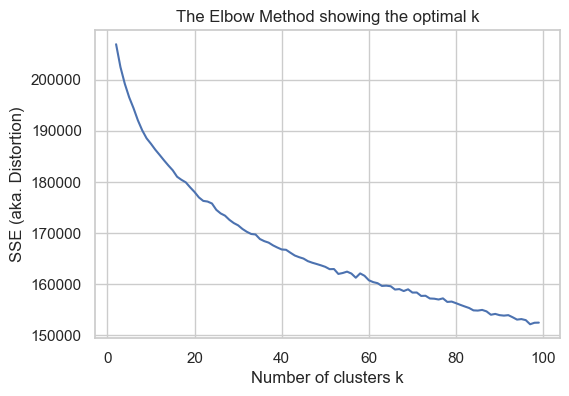

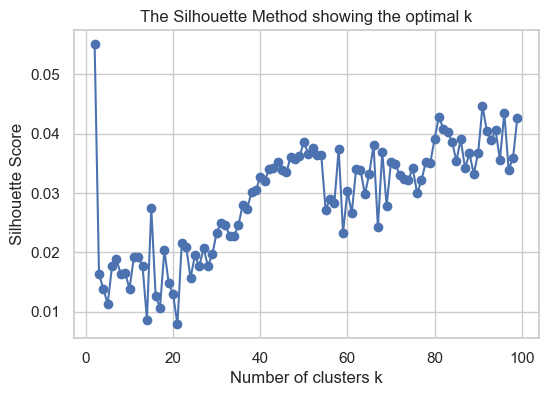

In [6]:
kmeans_fitted_models = compute_kmeans(X, 100)

- There's a elbow at around 50, and a steap dip in the sillhouette score around the same mark, looks like I can take k = 50

### 3. Fit a Kmeans model

In [7]:
k = 50
best_model = kmeans_fitted_models[k]
df['Cluster_id'] = y_pred = best_model.predict(X)

### 4. Visualize using a PCA (via SVD)

It has been show, that text vectorized in high-space dimensions like sBert does, PCA tends to under-perform since understanding eigenvectors without the knowledge of underlying meaning of these 768 dimensions does not make sense.

Text(0.5, 1.0, 'PCA Analysis')

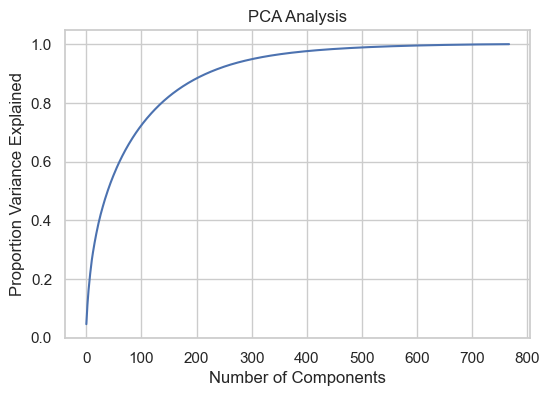

In [8]:
pca = PCA()
pca_data = pca.fit_transform(pd.DataFrame(X))

# store principal components
pca_data = pd.DataFrame(pca_data)
pca_data.columns = ["PC_%s" % i for i in range(1, len(pca_data.columns)+1)]

# check proportion of variance explained by these components
#print("pca.explained variance ratio:\n ", " ".join(map("{:.2f}".format, pca.explained_variance_ratio_)))
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Proportion Variance Explained')
plt.title('PCA Analysis')

- Since its random tweets, PCA isn't able to explain much of variability in its Eigenvectors. But typically, around 100 dimensions are enough to explain about 80% variability in the data.

### 5. Dimensionality Reduction with t-SNE

Using t-SNE we can reduce our 768 high dimensional features vector to 2 dimensions!

By using the 2 dimensions as x,y coordinates, the body_text can be plotted. t-SNE will attempt to preserve the relations of the higher dimensional data as closely as possible when shrunk to 2D. The similar article will thus be in closer proximity to each other.

.

**>> For high-dim text, t-SNE performs much better than PCA (SVD) <<**

.

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50)
X_embedded = tsne.fit_transform(X)

tsne_df = pd.DataFrame({"C1": X_embedded[:,0], "C2": X_embedded[:,1]})

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3394 samples in 0.003s...
[t-SNE] Computed neighbors for 3394 samples in 0.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3394
[t-SNE] Computed conditional probabilities for sample 2000 / 3394
[t-SNE] Computed conditional probabilities for sample 3000 / 3394
[t-SNE] Computed conditional probabilities for sample 3394 / 3394
[t-SNE] Mean sigma: 2.464484
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.633820
[t-SNE] KL divergence after 1000 iterations: 2.110776


#### t-SNE without labels

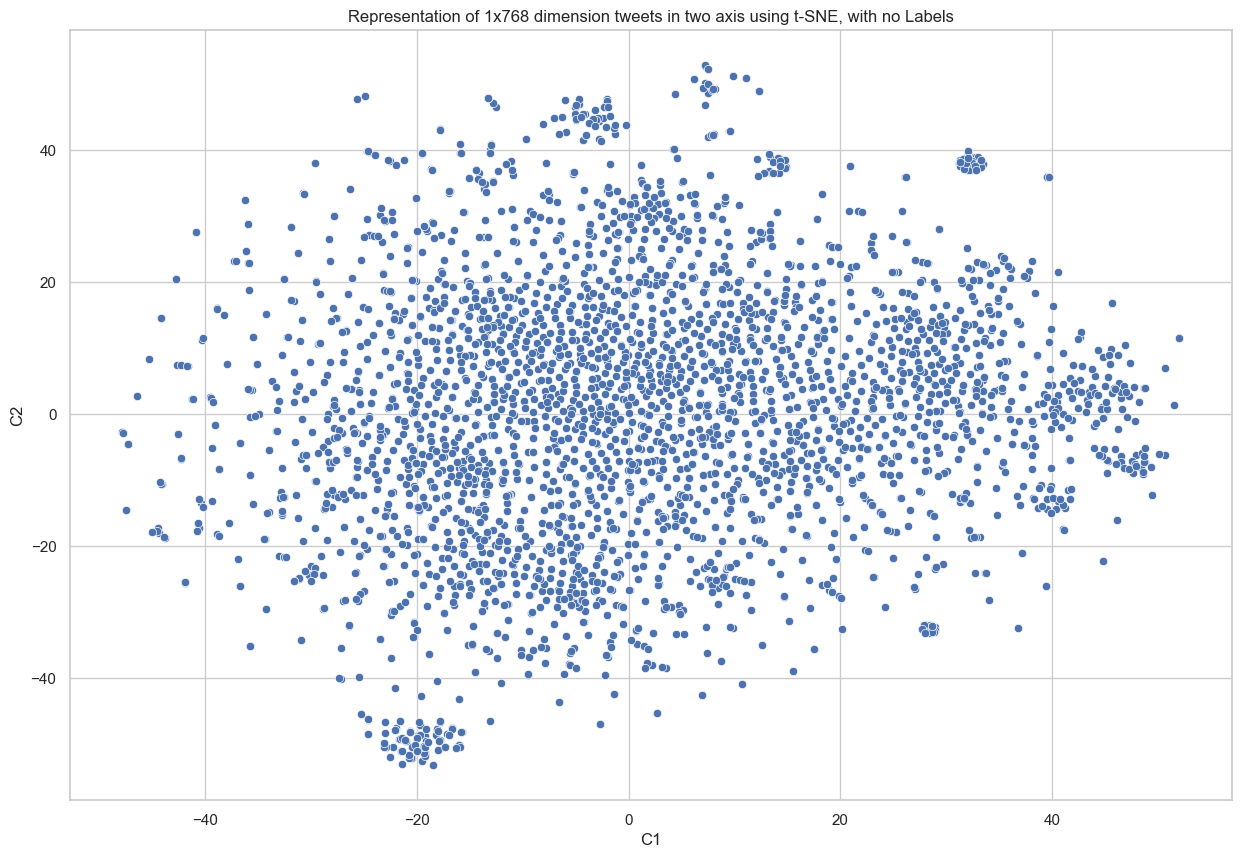

In [10]:
# plot
sns.scatterplot(x="C1", y="C2", data=tsne_df, palette='inferno')
plt.title('Representation of 1x768 dimension tweets in two axis using t-SNE, with no Labels')
plt.show()

#### t-SNE with k-Means predicted cluster ids (total cluster =50)

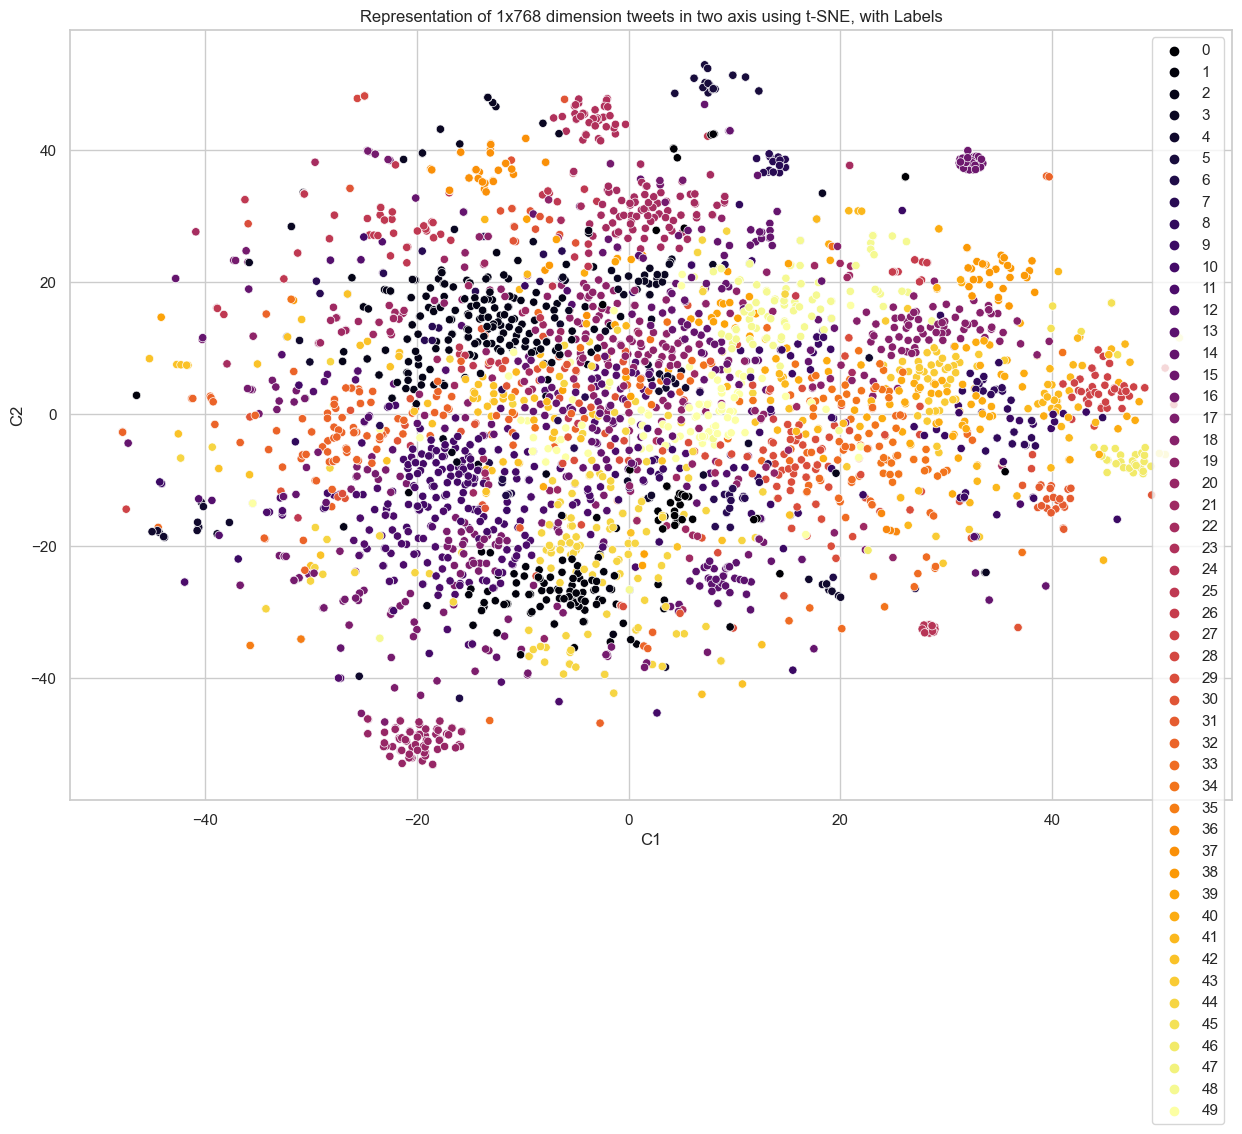

In [11]:
# plot
sns.scatterplot(x="C1", y="C2", data=tsne_df, hue=y_pred, legend='full', palette='inferno')
plt.title('Representation of 1x768 dimension tweets in two axis using t-SNE, with Labels')
plt.show()

- t-SNE does a good job in preserving dimensional understanding

## 6. Cluster Analysis

In [12]:
# viz only top 5 clusters

n = 5

In [13]:
# top n cluster_ids
top_n_clusters = df.groupby(['Cluster_id'])['tweet'].count()\
                    .reset_index()\
                    .sort_values(by='tweet', ascending=False)['Cluster_id'].values[:n]

# centorid info for these top_n cluster ids
top_n_centorids = pd.DataFrame(best_model.cluster_centers_).iloc[top_n_clusters]

# data for top_n_clusters
top_n_df = df[df.Cluster_id.isin(top_n_clusters)]
top_n_df_tweets = top_n_df.groupby(['Cluster_id']).agg({'tweet': list, 'Processed_tweet': list}).reset_index()
top_n_df_tweets

,Cluster_id,tweet,Processed_tweet
0,2,[Sobering presentation on academic metrics (ci...,[sobering presentation academic metric citatio...
1,14,[As an anthro PhD student I’m frequently asked...,[anthro phd student m frequently ask why study...
2,19,[@CUBoulder @GradBuffs @Old99Brewing @sesync M...,[make good progress week dissertation write re...
3,32,[#FPGA Design for #Embedded #Systems\n\n#SoC #...,[fpga design embed system soc verilog vlsi asi...
4,44,[The Venn diagram between climate and human he...,[venn diagram climate human health interview i...


In [14]:
def get_n_features(data, n):
    dfs = []
    for i, row in top_n_df_tweets.iterrows():

        # list of preprocessed tweets
        docs = row['Processed_tweet']
        
        vectorizer = TfidfVectorizer(stop_words = 'english')
        docs_vector = vectorizer.fit_transform(docs)
        
        # tf_idf matrix
        # rows    : each tweet (document);    
        # cols    : words;  
        # values  : tf-idf score
        tf_idf = pd.DataFrame(data=docs_vector.toarray(), columns=vectorizer.get_feature_names_out())

        # Word-Doc matrix
        words_tfidf = tf_idf.T 
        words_tfidf['avg_tfidf_score'] = np.mean(words_tfidf, axis=1)   # along rows
        #print(word_tfidf)

        # top n features
        # {'research': {'avg_score': 0.054}, 'environmental': {'avg_score': 0.024}, ... }
        ranked_word_tfidf = words_tfidf.sort_values(by=['avg_tfidf_score'], ascending=False)
        top_n_words_scores_dict = ranked_word_tfidf[['avg_tfidf_score']][:n].to_dict(orient='index')
        best_features = [(word, s['avg_tfidf_score']) for word, s in top_n_words_scores_dict.items()]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, top_n_clusters, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(6,4))
        sns.barplot(x='score' , y='features', orient='h', data = dfs[i][:n_feats], palette='inferno')
        plt.xlabel('Avg tf-idf score')
        plt.ylabel('Top words')
        plt.title(("Most Common Words in Cluster {}".format(top_n_clusters[i])), fontsize=10, fontweight='bold')
        plt.show()

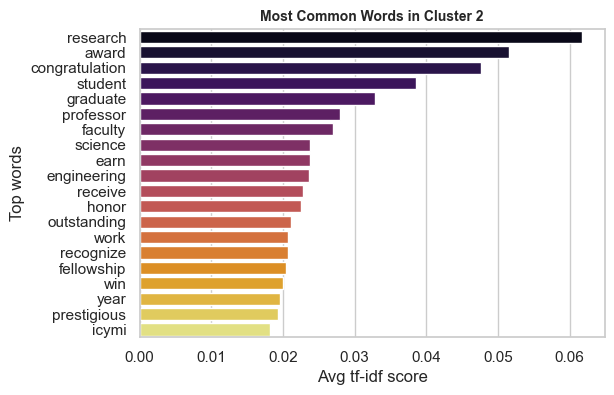

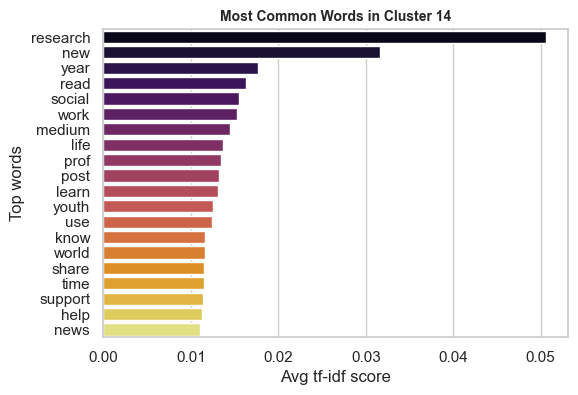

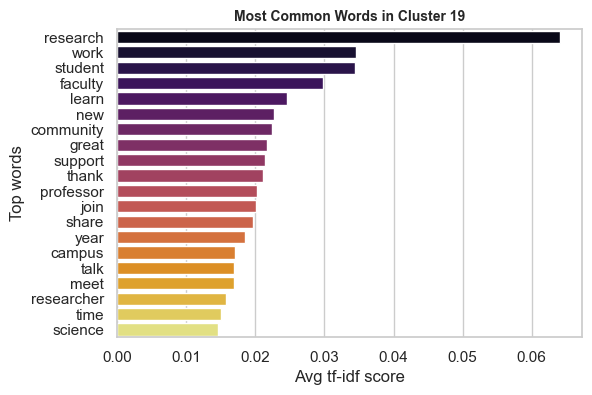

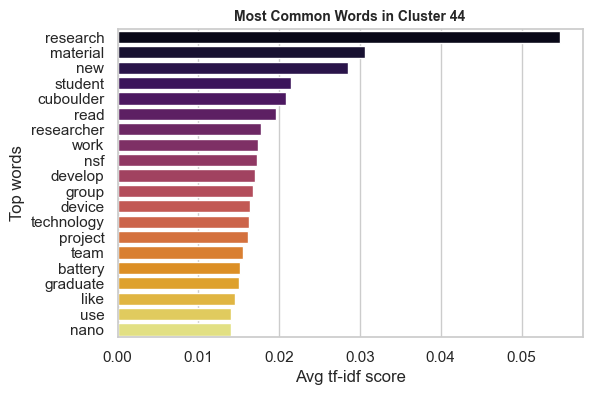

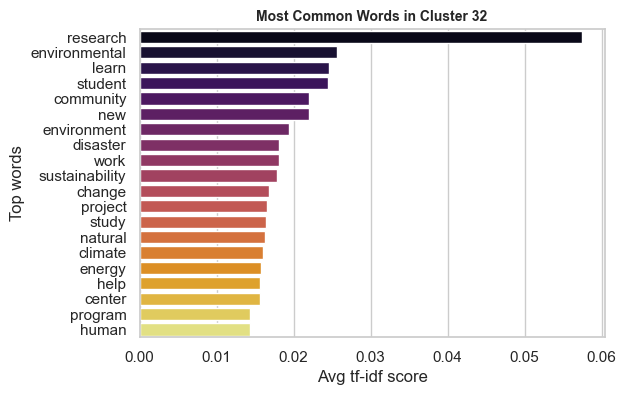

In [15]:
top_n_words_df = get_n_features(top_n_df_tweets, 20)
plotWords(top_n_words_df, top_n_clusters, 20)

In [17]:
# # Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
# def centroidsDict(centroids, index):
#     a = centroids.T[index].sort_values(ascending = False).reset_index().values
#     centroid_dict = dict()

#     for i in range(0, len(a)):
#         centroid_dict.update( {a[i,0] : a[i,1]} )

#     return centroid_dict

# def generateWordClouds(centroids):
#     wordcloud = WordCloud(max_font_size=100, background_color = 'white')
#     for i in range(0, len(centroids)):
#         centroid_dict = centroidsDict(centroids, i)        
#         wordcloud.generate_from_frequencies(centroid_dict)

#         plt.figure()
#         plt.title('Cluster {}'.format(i))
#         plt.imshow(wordcloud)
#         plt.axis("off")
#         plt.show()

### Dendrogram analysis with agglomerative

In [18]:
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, single, complete
from sklearn.metrics.pairwise import cosine_similarity

In [19]:
def tokenize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    return tokens

In [21]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(3,4), max_df=0.9, sublinear_tf=True, tokenizer=lambda x: x.split(" "))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_tweet'])

dist = 1 - cosine_similarity(tfidf_matrix)
dist = dist - dist.min()

linkage_matrix = ward(dist)

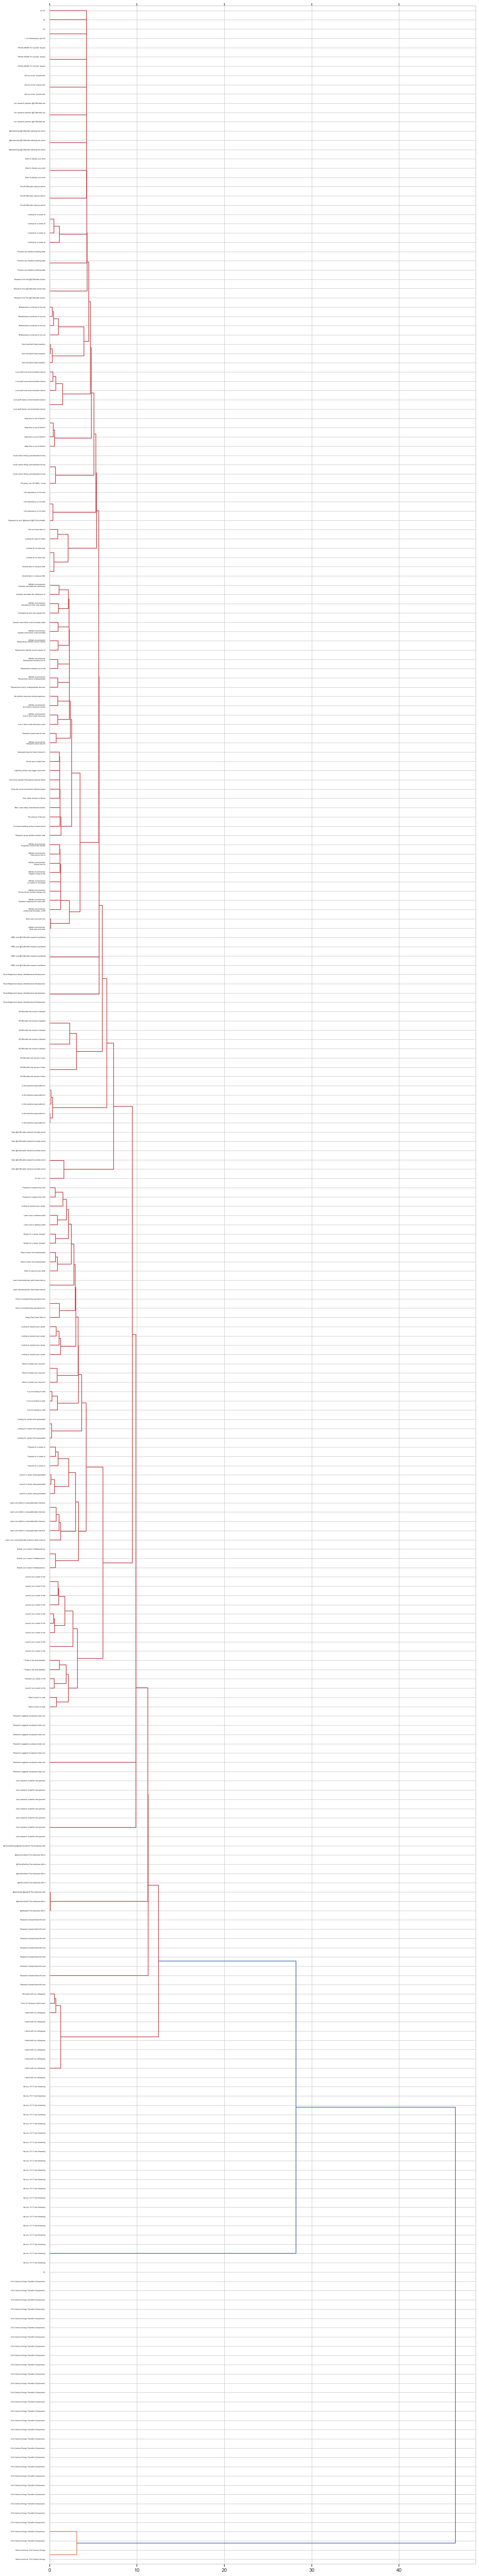

In [30]:
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39

fig, ax = plt.subplots(figsize=(15, 80))
ax = dendrogram(linkage_matrix, orientation="right", truncate_mode='level', color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4, labels=list(map(lambda x: " ".join(x.split(" ")[:5]), df['tweet'])))
plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')
plt.tight_layout()

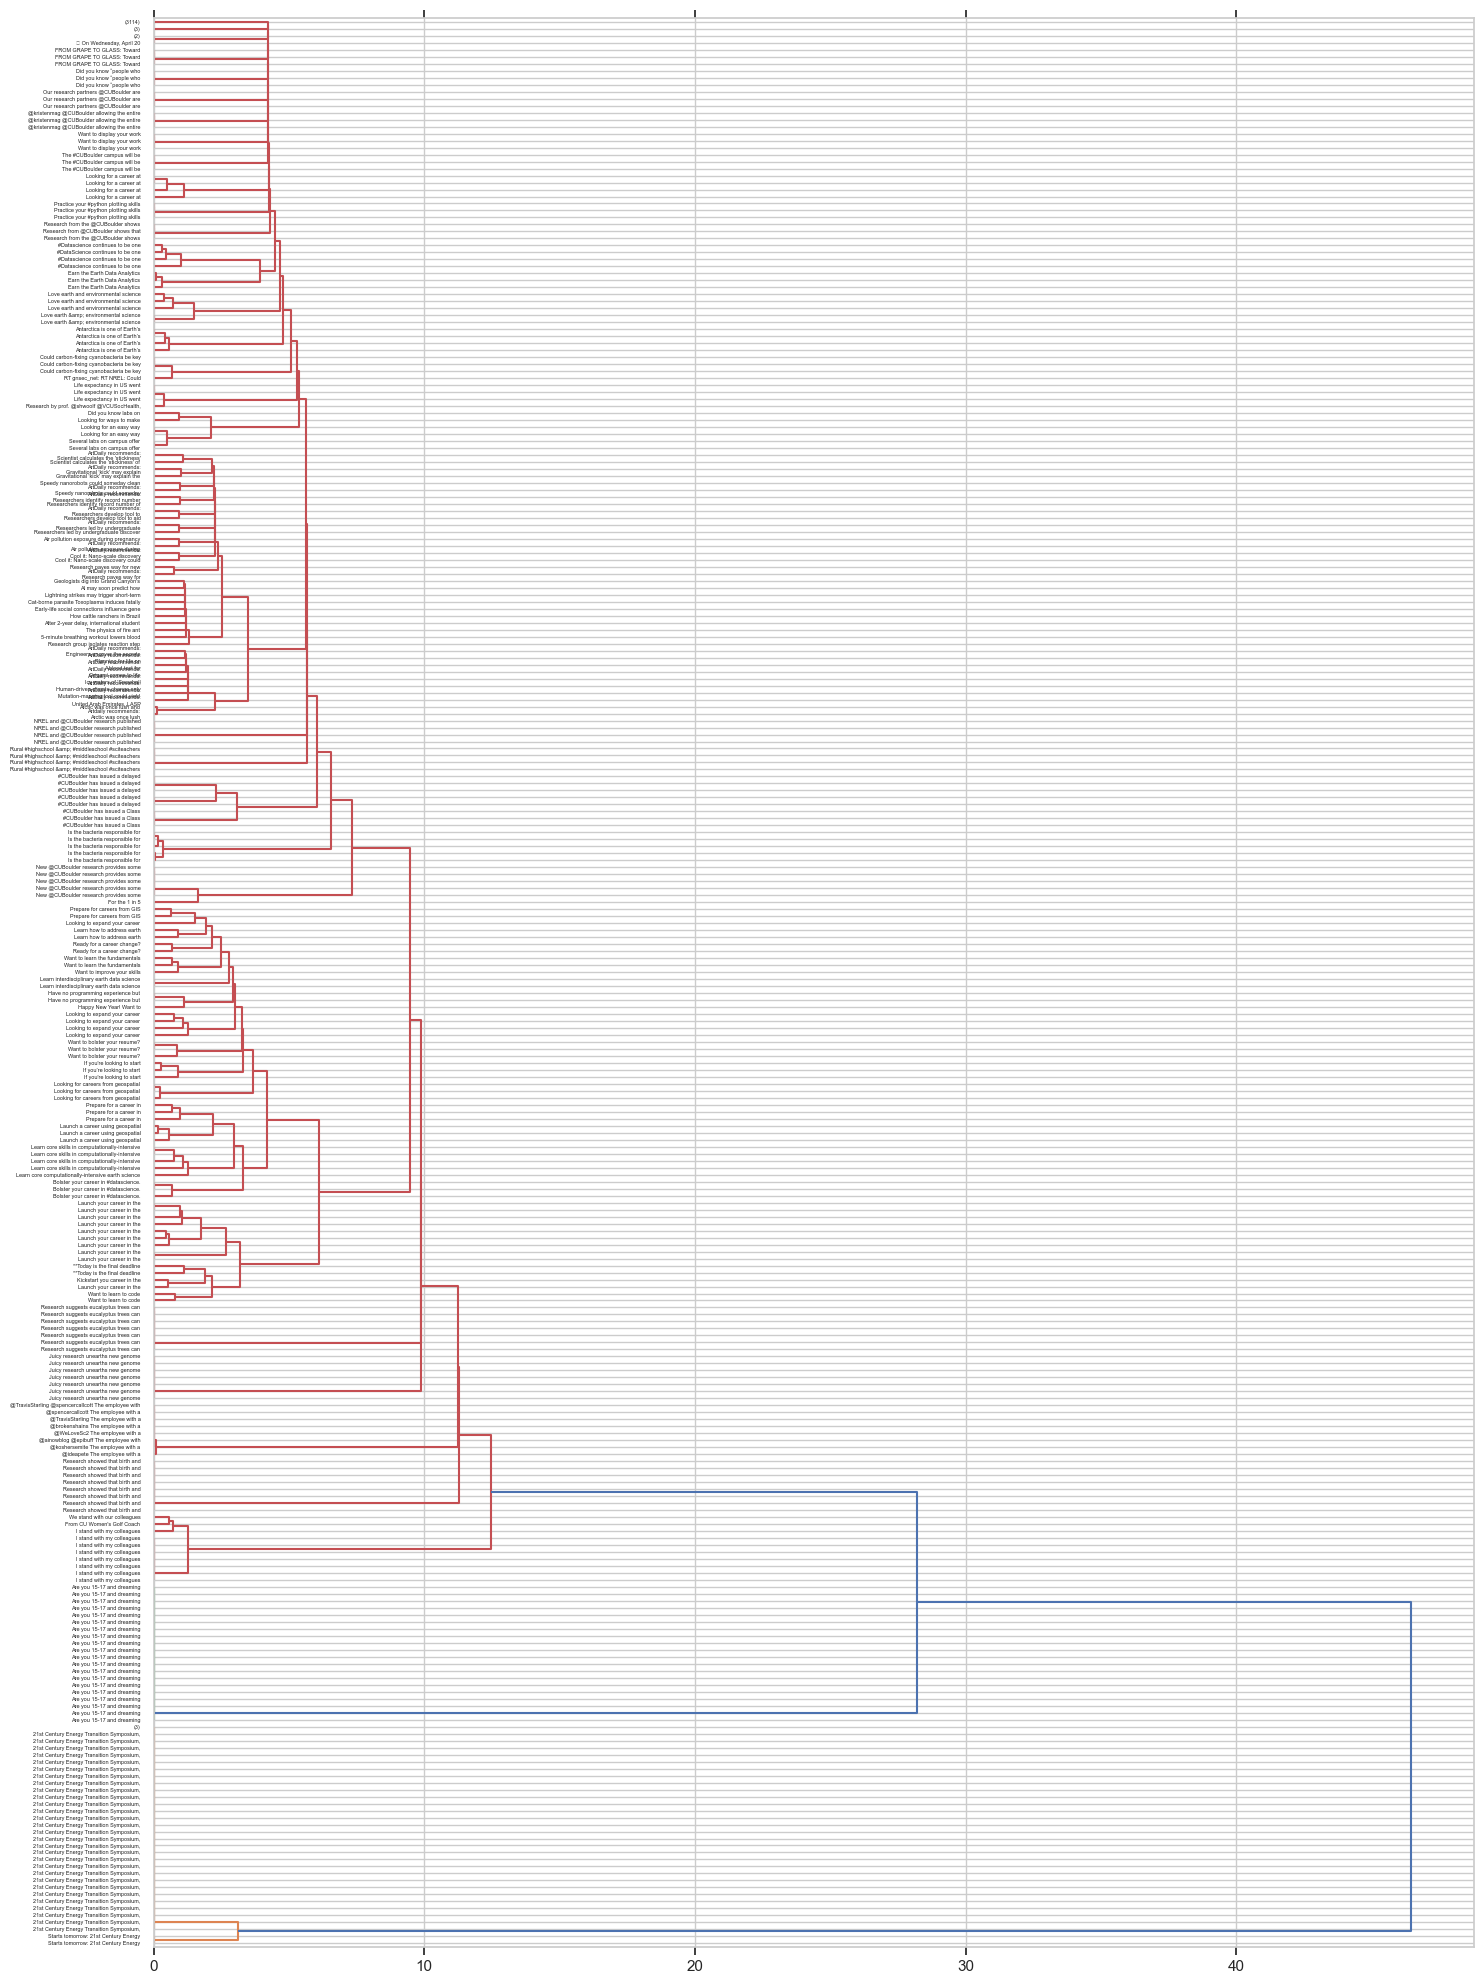

In [31]:
MAX_COPHENETIC_DIST = max(linkage_matrix[:,2]) * 0.39

fig, ax = plt.subplots(figsize=(15, 20))
ax = dendrogram(linkage_matrix, orientation="right", truncate_mode='level', color_threshold=MAX_COPHENETIC_DIST, leaf_font_size=4, labels=list(map(lambda x: " ".join(x.split(" ")[:5]), df['tweet'])))
plt.tick_params(axis= 'x', which='both',  bottom='off', top='off',labelbottom='off')
plt.tight_layout()